In [1]:
!pip install pillow numpy torch opencv-python matplotlib seaborn torchvision tqdm scikit-learn umap-learn

In [2]:
import cv2
import os
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from tqdm import tqdm
import numpy as np

# Define the folders containing the images
folders = {
    0: "../data/Dataset/Non_Demented/",
    1: "../data/Dataset/Very_Mild_Demented/",
    2: "../data/Dataset/Mild_Demented/",
    3: "../data/Dataset/Moderate_Demented/",
}

# Initialize lists to store the images and labels
X = []
y = []

corrupted = 0

# Iterate over the folders and load each image
for label, path in folders.items():
    for filename in tqdm(os.listdir(path)):
        # Load the image
        img_path = os.path.join(path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            img = np.zeros((128,128))
            corrupted += 1
        img_tensor = torch.from_numpy(img).float() 
        X.append(img_tensor)
        y.append(label)

X = torch.stack(X)
# Normalize the images
X = X / 255.0
y = torch.tensor(y)

print(X.shape, y.shape)
torch.save(X, 'X_tensor.pt')
torch.save(y, 'y_tensor.pt')

100%|██████████| 65/65 [00:01<00:00, 51.62it/s]


torch.Size([6404, 128, 128]) torch.Size([6404])


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
import numpy as np
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split

X = torch.load('X_tensor.pt')
y = torch.load('y_tensor.pt')

class CosineSimilarityLoss(nn.Module):
    def __init__(self):
        super(CosineSimilarityLoss, self).__init__()
        self.cosine_similarity = nn.CosineSimilarity(dim=1)

    def forward(self, outputs, targets):
        # Ensure the input and target tensors are flattened
        outputs_flat = outputs.view(outputs.size(0), -1)
        targets_flat = targets.view(targets.size(0), -1)
        
        # Calculate cosine similarity. This returns a value between -1 and 1.
        # Subtract from 1 to convert to loss. Lower is better.
        loss = 1 - self.cosine_similarity(outputs_flat, targets_flat).mean()
        return loss

class RandomMasking(nn.Module):
    def __init__(self, mask_ratio=0.6):
        super(RandomMasking, self).__init__()
        self.mask_ratio = mask_ratio

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        total_pixels = height * width
        num_masked = int(self.mask_ratio * total_pixels)
        
        # Create a mask for each image in the batch
        mask = torch.rand((batch_size, total_pixels)) < (1 - self.mask_ratio)
        mask = mask.float().view(batch_size, 1, height, width).to(x.device)
        return x * mask, mask

class CNNAutoencoder(nn.Module):
    def __init__(self, mask_ratio=0.5):
        super(CNNAutoencoder, self).__init__()
        self.masking = RandomMasking(mask_ratio=mask_ratio)
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        masked_x, mask = self.masking(x)
        encoded = self.encoder(masked_x)
        decoded = self.decoder(encoded)
        return decoded, encoded, mask

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNAutoencoder().to(device)
criterion = CosineSimilarityLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 10
losses = []

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
class_counts = y_train.bincount()
num_samples = y_train.size(0)
class_weights = 1. / class_counts

sample_weights = class_weights[y_train]

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=num_samples, replacement=True)
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

/home/ppxscal/miniconda3/envs/mit6300/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 95%|█████████▌| 153/161 [00:02<00:00, 85.32it/s]/home/ppxscal/miniconda3/envs/mit6300/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 161/161 [00:02<00:00, 74.71it/s]


Epoch 1, Training Loss: 0.33807563485566133


100%|██████████| 161/161 [00:01<00:00, 91.64it/s]


Epoch 2, Training Loss: 0.17801352132181203


100%|██████████| 161/161 [00:01<00:00, 92.35it/s]


Epoch 3, Training Loss: 0.0714285673562044


100%|██████████| 161/161 [00:01<00:00, 92.68it/s]


Epoch 4, Training Loss: 0.0509852978013317


100%|██████████| 161/161 [00:01<00:00, 90.27it/s]


Epoch 5, Training Loss: 0.04318136680200233


100%|██████████| 161/161 [00:01<00:00, 94.66it/s]


Epoch 6, Training Loss: 0.04157355964554023


100%|██████████| 161/161 [00:01<00:00, 96.96it/s]


Epoch 7, Training Loss: 0.039010919028927823


100%|██████████| 161/161 [00:01<00:00, 95.49it/s]


Epoch 8, Training Loss: 0.0379710086384175


100%|██████████| 161/161 [00:01<00:00, 96.82it/s]


Epoch 9, Training Loss: 0.03650272632977977


100%|██████████| 161/161 [00:01<00:00, 93.89it/s]


Epoch 10, Training Loss: 0.03455542592528444


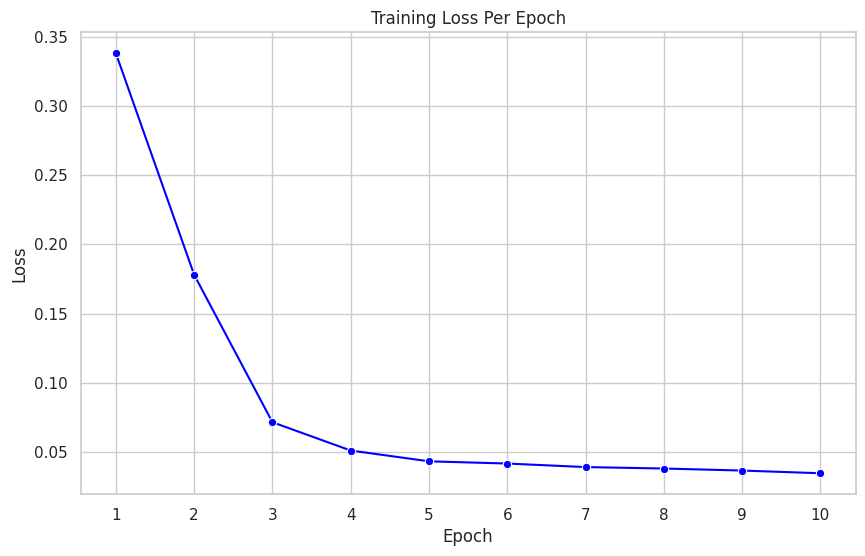

In [4]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, _ in tqdm(train_loader):
        images = images.unsqueeze(1).to(device)
        
        optimizer.zero_grad()
        reconstructed, _, mask = model(images)  # Ensure your model returns the mask as well
        # Apply the mask to both the reconstructed output and the original images
        # before computing the loss.
        loss = criterion(reconstructed * mask, images * mask)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    losses.append(epoch_loss)
    print(f'Epoch {epoch + 1}, Training Loss: {epoch_loss}')

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, num_epochs + 1), y=losses, marker='o', color='blue')
plt.title('Training Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, num_epochs + 1))
plt.show()

inferencing
reducing dimensions embeddings shape (6404, 64, 16, 16)


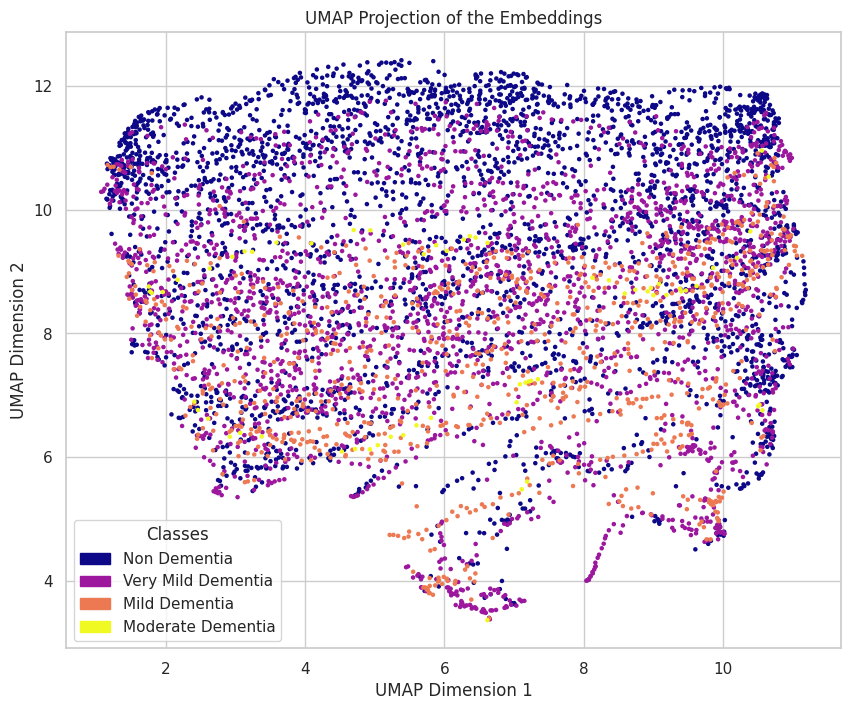

In [5]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from matplotlib.cm import plasma  # Import plasma colormap
from sklearn.decomposition import PCA

# Switch to evaluation mode
model.eval()

# Storage for embeddings and labels
embeddings = []
labels = []

print('inferencing')

with torch.no_grad():
    for images, label in DataLoader(TensorDataset(X, y), batch_size=32):
        images = images.unsqueeze(1).to(device)
        _, encoded, mask = model(images)  # Capture the mask output here
        embeddings.append(encoded.cpu().numpy())
        labels.append(label.numpy())

# Concatenate all batches
embeddings = np.concatenate(embeddings, axis=0)
labels = np.concatenate(labels, axis=0)

import umap.umap_ as umap

print('reducing dimensions', 'embeddings shape', embeddings.shape)
# Reduce dimensions
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean')
umap_embeddings = reducer.fit_transform(embeddings.reshape(embeddings.shape[0], -1))  # Reshape if necessary

labels_to_class = {
0: "Non Dementia",
1: "Very Mild Dementia",
2: "Mild Dementia",
3: "Moderate Dementia",
}

cmap = plasma

plt.figure(figsize=(10, 8),)
scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=labels, cmap=cmap, s=5)

# Create a legend
legend_handles = [mpatches.Patch(color=cmap(i / (len(labels_to_class) - 1)), label=labels_to_class[i]) for i in labels_to_class]
plt.legend(handles=legend_handles, title="Classes")

plt.title('UMAP Projection of the Embeddings')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()